# Smoothing solution to the MSD 

In [1]:
import gtsam
from typing import Optional, List
from functools import partial
from gtsam.symbol_shorthand import X
import numpy as np
import graphviz
import matplotlib.pyplot as plt

# Create factors functions

In [2]:
m = 1.0
k = 10.0
c = 1.0

A_C = np.array([[0, 1],
             [-k/m, -c/m]])
B_C = np.array([[0],
             [1/m]])
DT = 0.01

#c2d #https://en.wikipedia.org/wiki/Discretization
I = np.eye(2)
A_D = I + A_C * DT
B_D = np.linalg.inv(A_C) @ (A_D - I) @ B_C

def error_odom(f_nom: np.ndarray, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> float:
    """Odometry Factor error function
    :param measurement: Odometry measurement, to be filled with `partial`
    :param this: gtsam.CustomFactor handle
    :param values: gtsam.Values
    :param jacobians: Optional list of Jacobians
    :return: the unwhitened error
    """
    key1 = this.keys()[0]
    key2 = this.keys()[1]
    q1 = values.atVector(key1).reshape(-1,1) 
    q2 = values.atVector(key2).reshape(-1,1)

    q2_predict = A_D @ q1 + B_D * f_nom

    error = q2 - q2_predict

    #jacobians of h
    if jacobians is not None:
        jacobians[0] = - (np.eye(2) + A_D)
        jacobians[1] =  np.eye(2)

    return error

def error_z(measurement: np.ndarray, this: gtsam.CustomFactor,
              values: gtsam.Values,
              jacobians: Optional[List[np.ndarray]]) -> float:
    key = this.keys()[0]
    estimate = values.atVector(key)[0]
    error = estimate - measurement

    if jacobians is not None:
        jacobians[0] = np.array([[1.0, 0.0]])

    return error

# Constants

In [3]:
COV_R = np.diag([0.5*(3/m)*DT**2, 0.5*(3/m)*DT]) * 8
COV_Q = np.array([[0.05**2]])
COV_PRIOR = np.eye(2) * 1e-15

GTSAM_COV_PRIOR = gtsam.noiseModel.Gaussian.Covariance(COV_PRIOR)
GTSAM_COV_R = gtsam.noiseModel.Gaussian.Covariance(COV_R)
GTSAM_COV_Q = gtsam.noiseModel.Gaussian.Covariance(COV_Q)

# Simulation for data gathering

In [4]:
#INITALIZE
t_0 = 0
t_final = 10
t_vec =  np.arange(t_0, t_final, DT)

q = np.array([1,1]).reshape(-1,1)
history = {"gt": [q], "u": [], "z": []}

f_nom = 1.0
#SIMULATION
np.random.seed(1)
for t in t_vec[1:]:
    f_real = np.random.normal(f_nom,3)
    q = A_D @ q + B_D * f_real
    z = np.random.normal(q[0],0.05)

    history["u"].append(f_nom)
    history["z"].append(z)
    history["gt"].append(q)

# Building the factor graph

In [5]:
graph = gtsam.NonlinearFactorGraph()
graph.add(gtsam.PriorFactorPoint2(X(0), history['gt'][0] ,GTSAM_COV_PRIOR))
for i, (u_i, z_ip1) in enumerate(zip(history["u"],history["z"])):
    graph.add(gtsam.CustomFactor(GTSAM_COV_R, 
                                 [X(i), X(i+1)], 
                                 partial(error_odom, u_i)))
    graph.add(gtsam.CustomFactor(GTSAM_COV_Q, 
                                 [X(i+1)], 
                                 partial(error_z, z_ip1)))

In [6]:
graph.saveGraph("graph_MSD")
graphviz.render('dot','pdf',"graph_MSD") #creates PDF

'graph_MSD.pdf'

# Initalizing inital values for solver

In [7]:
q_dr = history["gt"][0]
history["dr"] = [q_dr] #add dead reckoning to history dictionary for later plots

initial_estimate = gtsam.Values()
initial_estimate.insert(X(0), q_dr)

for i, u_i in enumerate(history["u"]):

    q_dr = A_D @ q_dr + B_D * f_nom
    
    initial_estimate.insert(X(i+1), q_dr)

    history["dr"].append(q_dr)

# Solving with the optimizer

In [8]:
params = gtsam.GaussNewtonParams()
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate,params)

result = optimizer.optimize()
marginals = gtsam.Marginals(graph, result)

# Plot

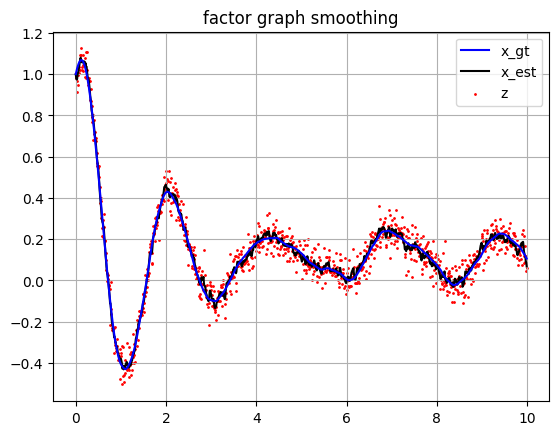

In [21]:
%matplotlib inline
# %matplotlib auto

gt = np.hstack([_[0] for _ in history["gt"]])
ests = np.array([result.atVector(X(i))[0] for i in range(len(t_vec))])
stds = np.array([np.sqrt(marginals.marginalCovariance(X(i))[0,0]) for i in range(len(t_vec))])
z = np.hstack([np.nan] + history["z"])

plt.figure()
graphics_est, = plt.plot(t_vec, ests, color = 'black')
graphics_z = plt.scatter(t_vec, z, s = 1, color = 'red')
graphics_gt, = plt.plot(t_vec, gt, color = 'blue')
plt.legend([graphics_gt, graphics_est, graphics_z], ['x_gt', 'x_est', 'z'])
plt.title('factor graph smoothing')
plt.grid(True)
plt.show()


# Compare to Kalman

# Compute Kalman Simulation (SAME RANDOM SEED!)

In [17]:
#KALMAN PARAMTERS - c2d #https://en.wikipedia.org/wiki/Discretization
I = np.eye(2)
A_D = (I + A_C * DT)
B_D = np.linalg.inv(A_C) @ (A_D - I) @ B_C

H = np.array([[1.0, 0]])
COV_R = np.diag([0.5*(3/m)*DT**2, 0.5*(3/m)*DT])
COV_Q = np.array([[0.05**2]])
COV_PRIOR = np.eye(2) * 1e-15

#inital state
q_gt = np.array([1,1]).reshape(-1,1)
q_est_mu = np.array([1,1]).reshape(-1,1)
q_est_cov = COV_PRIOR


def kalman(q_prev, cov_prev, f, z):
    #predict
    mu_bar = A_D @ q_prev + B_D * f
    cov_bar = A_D @ cov_prev @ A_D.T + COV_R
    
    #update
    K = cov_bar @ H.T @ np.linalg.inv(H @ cov_bar @ H.T + COV_Q)
    mu = mu_bar + K @ (z - H @ mu_bar)
    cov = (I - K @ H) @ cov_bar
    return mu, cov, K

history_kalman = {'gt': [q_gt[0,0]],
            'est': [q_est_mu[0,0]],
            'est_std': [np.sqrt(q_est_cov[0,0])],
            }
#SIMULATION
np.random.seed(1) #<-------------------------------------------------- SAME RANDOM SEED!!!!
for t in t_vec[1:]:
    f_real = np.random.normal(f_nom,3)
    q_gt = A_D @ q_gt + B_D * f_real
    z = np.random.normal(q_gt[0],0.05)

    q_est_mu, q_est_cov, K = kalman(q_est_mu, q_est_cov ,f_nom ,z)

    history_kalman['gt'].append(q_gt[0,0])
    history_kalman['est'].append(q_est_mu[0,0])
    history_kalman['est_std'].append(np.sqrt(q_est_cov[0,0]))

## Plot Comparison

In [22]:
# %matplotlib inline
%matplotlib auto

gt = np.hstack([_[0] for _ in history["gt"]])
fg_ests = np.array([result.atVector(X(i))[0] for i in range(len(t_vec))])
z = np.hstack([np.nan] + history["z"])

plt.figure()
graphics_fg_est, = plt.plot(t_vec, fg_ests, color = 'black')
graphics_kalman_est, = plt.plot(t_vec, history_kalman['est'], color = 'green')
graphics_z = plt.scatter(t_vec, z, s = 1, color = 'red')
graphics_gt, = plt.plot(t_vec, gt, color = 'blue')
plt.legend([graphics_gt, graphics_z,graphics_fg_est, graphics_kalman_est], ['x_gt', 'z', 'factor graph est', 'kalman est'])
plt.grid(True)
plt.show()


Using matplotlib backend: TkAgg
